In [3]:
import sys

from collections import Counter

import torch
from torch import nn

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import random
import os

import pandas as pd

from celeb_backbone import *
from basic_task import *

In [11]:
class CelebAEmbeddingsDataset(Dataset):
    def __init__(self, root="celebA_embeddings/", series_length=5, ):
        self.root = root
        self.series_length = series_length 
        self.stim_dir = Path(root, f"seq{series_length}")

    def __len__(self):
        files = list(self.stim_dir.glob('*.pt'))
        return len(files)

    def __getitem__(self, idx):
        idx = idx + 1
        item_path = Path(self.root, f"seq{series_length}", f"{idx:06d}.pt")
        item = torch.load(item_path, weights_only=False)

        sequence = item["sequence"]
        sequence = sequence.squeeze(2) 
        
        label = item["label"]      
        label = torch.tensor(label, dtype=torch.long)

        return (sequence, label)



def train(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs=5):
    batches_list = []
    loss_list = []



    train_accuracy_list = []
    val_accuracy_list = []

    for epoch in range(num_epochs):
        model.train()
        for i, (sequences, labels) in enumerate(train_dataloader):
        
            sequences = sequences.to('cuda')
            labels = labels.to('cuda')
            sequences = sequences.squeeze(2) 
            preds = model(sequences)
            
            loss = criterion(preds.squeeze(), labels.float().squeeze())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds_ = torch.softmax(preds, dim=2)
            correct = (preds_.argmax(dim=2).T == labels.argmax(dim=1)).float().sum()
            
            batches_list.append(i)
            loss_list.append(loss.item())

            if i % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_dataloader)}], Loss: {loss.item():.4f}, Accuracy: {correct.item()}/{labels.size(0)} ({100 * correct.item() / (labels.size(0)):.2f}%)')
        

        acc = validate(model, train_dataloader, criterion, epoch)
        train_accuracy_list.append(acc)

        acc = validate(model, val_dataloader, criterion, epoch)
        val_accuracy_list.append(acc)

    return batches_list, loss_list, train_accuracy_list, val_accuracy_list

def validate(model, val_dataloader, criterion, epoch):
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sequences, labels in val_dataloader:
            
            sequences = sequences.to('cuda')
            labels = labels.to('cuda')

            sequences = sequences.squeeze(2) 
            preds = model(sequences)
            
            loss = criterion(preds.squeeze(), labels.float().squeeze())

            preds_ = torch.softmax(preds, dim=2)
            temp = (preds_.argmax(dim=2).T == labels.argmax(dim=1)).float().sum()
            correct += temp.item()
            total += labels.size(0)
            
    sequence_length = labels.size(1)
    
    path = Path(f"models/vanilla_rnn/seq{sequence_length}/checkpoints/")
    path.mkdir(exist_ok=True, parents=True)

    print(f'Validation Accuracy: {100 * correct / total}%')
    torch.save(model.state_dict(), path / f'epoch{epoch}.pth')
    return 100 * correct / total

def test(model, test_dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for sequences, labels in test_dataloader:
            
            sequences = sequences.to('cuda')
            labels = labels.to('cuda')

            sequences = sequences.squeeze(2) 
            preds = model(sequences)

            preds_ = torch.softmax(preds, dim=2)
            temp = (preds_.argmax(dim=2).T == labels.argmax(dim=1)).float().sum()
            correct += temp.item()
            total += labels.size(0)

    print(f'Test Accuracy: {100 * correct / total}%')



In [5]:
series_length = 5
batch_size = 128
seed_value = 100

train_dataloader, val_dataloader, test_dataloader = data_prepper(series_length, batch_size, seed_value,)

train:
Counter({4: 14103, 3: 10525, 2: 7114, 1: 3538})

val
Counter({4: 3088, 3: 2265, 2: 1484, 1: 723})

test
Counter({4: 2969, 3: 2330, 2: 1482, 1: 779})


In [6]:
num_epochs = 15

In [12]:
### seq length 5

# series_length = 5
# batch_size = 128
# seed_value = 100

# train_dataloader, val_dataloader, test_dataloader = data_prepper(series_length, batch_size, seed_value,)

model = Vanilla_RNN(input_size=4096, hidden_size=1024, num_layers=1, num_classes=series_length).to('cuda')

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#num_epochs = 10

five = train(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs)

test(model, test_dataloader)

Epoch [1/15], Step [1/275], Loss: 1.6108, Accuracy: 26.0/128 (20.31%)
Epoch [1/15], Step [11/275], Loss: 1.3968, Accuracy: 46.0/128 (35.94%)
Epoch [1/15], Step [21/275], Loss: 1.2403, Accuracy: 59.0/128 (46.09%)
Epoch [1/15], Step [31/275], Loss: 1.3468, Accuracy: 49.0/128 (38.28%)
Epoch [1/15], Step [41/275], Loss: 1.2478, Accuracy: 57.0/128 (44.53%)
Epoch [1/15], Step [51/275], Loss: 1.3233, Accuracy: 43.0/128 (33.59%)
Epoch [1/15], Step [61/275], Loss: 1.2545, Accuracy: 50.0/128 (39.06%)
Epoch [1/15], Step [71/275], Loss: 0.9861, Accuracy: 75.0/128 (58.59%)
Epoch [1/15], Step [81/275], Loss: 0.8049, Accuracy: 83.0/128 (64.84%)
Epoch [1/15], Step [91/275], Loss: 0.4381, Accuracy: 110.0/128 (85.94%)
Epoch [1/15], Step [101/275], Loss: 0.2901, Accuracy: 117.0/128 (91.41%)
Epoch [1/15], Step [111/275], Loss: 0.1440, Accuracy: 124.0/128 (96.88%)
Epoch [1/15], Step [121/275], Loss: 0.1218, Accuracy: 120.0/128 (93.75%)
Epoch [1/15], Step [131/275], Loss: 0.0964, Accuracy: 125.0/128 (97.66%

In [22]:
### seq length 6

series_length = 6
batch_size = 128
seed_value = 100

train_dataloader, val_dataloader, test_dataloader = data_prepper(series_length, batch_size, seed_value,)

model = Vanilla_RNN(input_size=4096, hidden_size=1024, num_layers=1, num_classes=series_length).to('cuda')

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#num_epochs = 10

six = train(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs)

test(model, test_dataloader)

train:


In [24]:
### seq length 7

series_length = 7
batch_size = 128
seed_value = 100

train_dataloader, val_dataloader, test_dataloader = data_prepper(series_length, batch_size, seed_value,)

model = Vanilla_RNN(input_size=4096, hidden_size=1024, num_layers=1, num_classes=series_length).to('cuda')

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#num_epochs = 10

seven = train(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs)

test(model, test_dataloader)

train:
Counter({6: 14333, 5: 8477, 4: 5614, 3: 3551, 2: 2054, 1: 959})

val
Counter({6: 3094, 5: 1802, 4: 1220, 3: 754, 2: 447, 1: 180})

test
Counter({6: 2989, 5: 1802, 4: 1227, 3: 794, 2: 455, 1: 232})
Epoch [1/15], Step [1/273], Loss: 1.9563, Accuracy: 17.0/128 (13.28%)
Epoch [1/15], Step [11/273], Loss: 1.4882, Accuracy: 58.0/128 (45.31%)
Epoch [1/15], Step [21/273], Loss: 1.5577, Accuracy: 51.0/128 (39.84%)
Epoch [1/15], Step [31/273], Loss: 1.4230, Accuracy: 60.0/128 (46.88%)
Epoch [1/15], Step [41/273], Loss: 1.4229, Accuracy: 57.0/128 (44.53%)
Epoch [1/15], Step [51/273], Loss: 1.5018, Accuracy: 53.0/128 (41.41%)
Epoch [1/15], Step [61/273], Loss: 1.5327, Accuracy: 55.0/128 (42.97%)
Epoch [1/15], Step [71/273], Loss: 1.5937, Accuracy: 44.0/128 (34.38%)
Epoch [1/15], Step [81/273], Loss: 1.5363, Accuracy: 46.0/128 (35.94%)
Epoch [1/15], Step [91/273], Loss: 1.5562, Accuracy: 46.0/128 (35.94%)
Epoch [1/15], Step [101/273], Loss: 1.5157, Accuracy: 52.0/128 (40.62%)
Epoch [1/15], S

In [25]:
### seq length 8

series_length = 8
batch_size = 128
seed_value = 100

train_dataloader, val_dataloader, test_dataloader = data_prepper(series_length, batch_size, seed_value,)

model = Vanilla_RNN(input_size=4096, hidden_size=1024, num_layers=1, num_classes=series_length).to('cuda')

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#num_epochs = 10
 
eight = train(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs)

test(model, test_dataloader)

train:
Counter({7: 12956, 6: 7904, 5: 5538, 4: 3814, 3: 2503, 2: 1522, 1: 751})

val
Counter({7: 2834, 6: 1641, 5: 1166, 4: 818, 3: 552, 2: 345, 1: 141})

test
Counter({7: 2760, 6: 1685, 5: 1173, 4: 828, 3: 571, 2: 332, 1: 150})
Epoch [1/15], Step [1/273], Loss: 2.0775, Accuracy: 17.0/128 (13.28%)
Epoch [1/15], Step [11/273], Loss: 1.8824, Accuracy: 32.0/128 (25.00%)
Epoch [1/15], Step [21/273], Loss: 1.7362, Accuracy: 44.0/128 (34.38%)
Epoch [1/15], Step [31/273], Loss: 1.6688, Accuracy: 53.0/128 (41.41%)
Epoch [1/15], Step [41/273], Loss: 1.6558, Accuracy: 43.0/128 (33.59%)
Epoch [1/15], Step [51/273], Loss: 1.6846, Accuracy: 48.0/128 (37.50%)
Epoch [1/15], Step [61/273], Loss: 1.6927, Accuracy: 42.0/128 (32.81%)
Epoch [1/15], Step [71/273], Loss: 1.6222, Accuracy: 51.0/128 (39.84%)
Epoch [1/15], Step [81/273], Loss: 1.7204, Accuracy: 48.0/128 (37.50%)
Epoch [1/15], Step [91/273], Loss: 1.5463, Accuracy: 52.0/128 (40.62%)
Epoch [1/15], Step [101/273], Loss: 1.7312, Accuracy: 38.0/128

In [26]:
### seq length 10

series_length = 10
batch_size = 128
seed_value = 100

train_dataloader, val_dataloader, test_dataloader = data_prepper(series_length, batch_size, seed_value,)

model = Vanilla_RNN(input_size=4096, hidden_size=1024, num_layers=1, num_classes=series_length).to('cuda')

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#num_epochs = 10
ten = train(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs)

test(model, test_dataloader)

train:
Counter({9: 11129, 8: 6976, 7: 5131, 6: 3914, 5: 2901, 4: 2085, 3: 1455, 2: 964, 1: 433})

val
Counter({9: 2405, 8: 1545, 7: 1105, 6: 816, 5: 619, 4: 427, 3: 304, 2: 193, 1: 83})

test
Counter({9: 2344, 8: 1525, 7: 1126, 6: 873, 5: 634, 4: 428, 3: 306, 2: 183, 1: 80})
Epoch [1/15], Step [1/273], Loss: 2.3040, Accuracy: 8.0/128 (6.25%)
Epoch [1/15], Step [11/273], Loss: 2.1772, Accuracy: 22.0/128 (17.19%)
Epoch [1/15], Step [21/273], Loss: 1.8725, Accuracy: 20.0/128 (15.62%)
Epoch [1/15], Step [31/273], Loss: 1.9461, Accuracy: 36.0/128 (28.12%)
Epoch [1/15], Step [41/273], Loss: 1.7538, Accuracy: 50.0/128 (39.06%)
Epoch [1/15], Step [51/273], Loss: 1.7897, Accuracy: 46.0/128 (35.94%)
Epoch [1/15], Step [61/273], Loss: 1.9494, Accuracy: 40.0/128 (31.25%)
Epoch [1/15], Step [71/273], Loss: 1.9554, Accuracy: 34.0/128 (26.56%)
Epoch [1/15], Step [81/273], Loss: 1.8337, Accuracy: 38.0/128 (29.69%)
Epoch [1/15], Step [91/273], Loss: 1.9579, Accuracy: 42.0/128 (32.81%)
Epoch [1/15], Ste

In [17]:
colors =sns.color_palette("Spectral", 5)

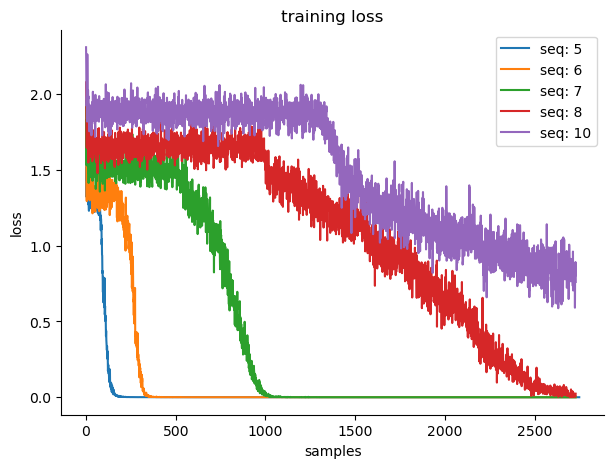

In [12]:
names = [5, 6, 7, 8, 10]
colors = sns.color_palette("Spectral", len(names))

fig, axes = plt.subplots(1, 1, figsize=(7, 5))

ax = axes
for i, item in enumerate([five, six, seven, eight, ten]):
    name = names[i]
    ax.plot(item[1], label=f"seq: {name}")

ax.set_ylabel("loss")
ax.set_xlabel("samples")
ax.set_title("training loss")
ax.legend()

sns.despine()

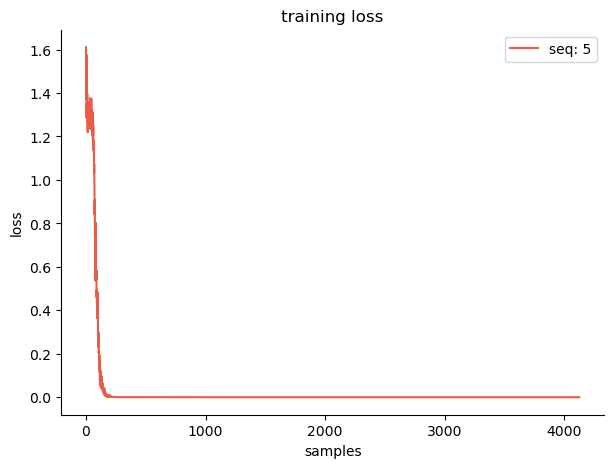

In [18]:
names = [5, ]

fig, axes = plt.subplots(1, 1, figsize=(7, 5))

ax = axes
for i, item in enumerate([five, ]):
    name = names[i]
    c = colors[0]
    ax.plot(item[1], label=f"seq: {name}", c=c)

ax.set_ylabel("loss")
ax.set_xlabel("samples")
ax.set_title("training loss")
ax.legend()

sns.despine()

In [21]:
five[-1]

[100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0]

In [19]:
ten[3]

[32.11206896551724,
 32.017780172413794,
 32.07165948275862,
 32.09859913793103,
 39.41271551724138,
 55.03771551724138,
 59.213362068965516,
 62.41918103448276,
 67.10668103448276,
 69.69288793103448]

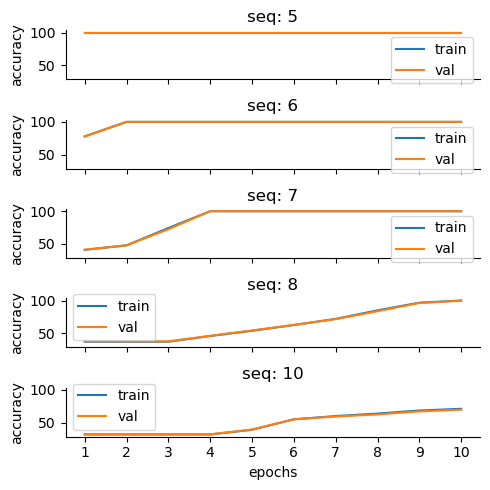

In [20]:
names = [5, 6, 7, 8, 10]

fig, axes = plt.subplots(len(names), 1, figsize=(5,5), sharex=True, sharey=True)

for i, item in enumerate([five, six, seven, eight, ten]):
    ax = axes[i]

    name = names[i]
    ax.plot(item[2], label=f"train")
    ax.plot(item[3], label=f"val")

    ax.set_ylabel("accuracy")
    if i == len(names)-1:
        ax.set_xlabel("epochs")
        ax.set_xticks(range(0,10))
        ax.set_xticklabels(range(1, 11))
    ax.set_title(f"seq: {name}")
    ax.legend()

plt.tight_layout()

sns.despine()